##Chatbot Transformer

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools
import json
import math
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset,DataLoader
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from collections import Counter

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
CUDA= torch.cuda.is_available()
device=torch.device("cuda" if CUDA else "cpu")

In [ ]:
base='/content/drive/MyDrive/Research/Chatbot_GRU/'
os.chdir(base)
corpus_name='Daily_Dialog_Hindi'
formatted_dialogs_file=os.path.join(base,'formatted_hindi_train_merged.txt')
formatted_val_file=os.path.join(base,'formatted_hindi_val.txt')
formatted_test_file=os.path.join(base,'formatted_hindi_test.txt')

In [ ]:
fasttext='/content/drive/MyDrive/Chatbot_research/fastText'
os.chdir(fasttext)
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/.shortcut-targets-by-id/1T6l4xRdCXp4XqFlU2jinSImxAHDOS9be/Chatbot_research/fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4381862 sha256=721e7628e25ef89a3381e332d51caf34a7eb4ff482b2a4be98b71fcfac7cabac
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhcn01z3/wheels/40/3d/d1/b95cc40292178b04d2e652bc831a3357b5812c4455f530c04e
Successfully built fasttext


In [ ]:
%cd ..

/content/drive/.shortcut-targets-by-id/1T6l4xRdCXp4XqFlU2jinSImxAHDOS9be/Chatbot_research


In [ ]:
import fasttext
ft_model = fasttext.load_model('cc.hi.300.bin')

In [ ]:
os.chdir(base)

In [ ]:
!ls

Chatbot_GRU.ipynb		  formatted_hindi_val.txt
Chatbot_Transformer.ipynb	  pairs_encoded_train.json
en-indic.zip			  pairs_encoded_val.json
formatted_hindi_test.txt	  Preprocessing.ipynb
formatted_hindi_train_merged.txt  results


In [ ]:
PAD_tok=0
SOS_tok=1
EOS_tok=2
OOV_tok=3

class Vocabulary:
  def __init__(self,name):
    self.name=name
    self.word2idx={'PAD':PAD_tok,'SOS':SOS_tok,'EOS':EOS_tok,'OOV':OOV_tok}
    self.word2count={}
    self.idx2word={PAD_tok:'PAD',SOS_tok:'SOS',EOS_tok:'EOS',OOV_tok:'OOV'}
    self.num_words=4
  
  def addLine(self,line):
    for word in line.split(' '):
      self.addWord(word)
  def addWord(self,word):
    if word not in self.word2idx:
      self.word2idx[word]=self.num_words
      self.word2count[word]=1
      self.idx2word[self.num_words]=word
      self.num_words+=1
    else:
      self.word2count[word] += 1

In [ ]:
def normalizeString(text):
  # s = unicodeToASCII(s.lower().strip())
   text = text.lower()
   text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
   text = re.sub('@[^s]+','',text)
   text = re.sub('[s]+', ' ', text)
   text = re.sub(r'#([^s]+)', r'1', text)
   text = re.sub('[.!:?-]', '', text)
   text = re.sub('[a-zA-Z0-9]','',text)
   text = re.sub(' +', ' ',text)
   text = text.strip('""')
   return text

In [ ]:
print('Reading Train File please wait...')
lines=open(formatted_dialogs_file,).read().strip().split('\n')
pairs_data_train=[[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print('Done Reading.....')

Reading Train File please wait...
Done Reading.....


In [ ]:
print('Reading validation File please wait...')
lines=open(formatted_val_file).read().strip().split('\n')
pairs_data_val=[[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print('Done Reading.....')

Reading validation File please wait...
Done Reading.....


In [ ]:
print('Reading test File please wait...')
lines=open(formatted_test_file).read().strip().split('\n')
pairs_data_test=[[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print('Done Reading.....')

Reading test File please wait...
Done Reading.....


In [ ]:
MAX_LENGTH=16
# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
def filterPair(p):
  return len(p[0].split())<MAX_LENGTH and len(p[1].split())<MAX_LENGTH

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [ ]:
pairs_train=[pair for pair in pairs_data_train if len(pair)>1]
print("There are {} pairs in the train dataset".format(len(pairs_train)))
pairs_train=filterPairs(pairs_train)
print('After filtering, there are {} pair'.format(len(pairs_train)))

pairs_val=[pair for pair in pairs_data_val if len(pair)>1]
print("There are {} pairs in the val dataset".format(len(pairs_val)))
pairs_val=filterPairs(pairs_val)
print('After filtering, there are {} pair'.format(len(pairs_val)))

pairs_test=[pair for pair in pairs_data_test if len(pair)>1]
print("There are {} pairs in the test dataset".format(len(pairs_test)))
pairs_test=filterPairs(pairs_test)
print('After filtering, there are {} pair'.format(len(pairs_test)))

There are 76053 pairs in the train dataset
After filtering, there are 43534 pair
There are 7069 pairs in the val dataset
After filtering, there are 4076 pair
There are 6740 pairs in the test dataset
After filtering, there are 3814 pair


In [ ]:
print('Creating Vocabulary....')
vocab=Vocabulary(corpus_name)

for pair in pairs_train:
  vocab.addLine(pair[0])
  vocab.addLine(pair[1])
print("counted words:",vocab.num_words)

Creating Vocabulary....
counted words: 13906


In [ ]:
emb_dim=300
embedding_matrix = np.zeros((vocab.num_words, emb_dim))

for i, word in enumerate(vocab.word2idx):
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
    else:
        embedding_matrix[i] = np.random.randn(emb_dim)

In [ ]:
def encode_question(sentence,vocab):
  enc=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in sentence.split()] + [vocab.word2idx['PAD']]*(MAX_LENGTH- len(sentence.split()))
  return enc

def encode_reply(sentence,vocab):
  enc=[vocab.word2idx['SOS']]+[vocab.word2idx.get(word,vocab.word2idx['OOV'])  for word in sentence.split()] +[vocab.word2idx['EOS']]+ [vocab.word2idx['PAD']]*(MAX_LENGTH- len(sentence.split()))
  return enc
  

In [ ]:
pairs_encoded_train=[]
for pair in pairs_train:
  ques=encode_question(pair[0],vocab)
  reply=encode_reply(pair[1],vocab)
  pairs_encoded_train.append([ques,reply])

with open('pairs_encoded_train.json','w') as fp1:
  json.dump(pairs_encoded_train,fp1)

pairs_encoded_val=[]
for pair in pairs_val:
  ques=encode_question(pair[0],vocab)
  reply=encode_reply(pair[1],vocab)
  pairs_encoded_val.append([ques,reply])

with open('pairs_encoded_val.json','w') as fp2:
  json.dump(pairs_encoded_val,fp2)

In [ ]:
class Dataset():
  def __init__(self,filename):
    self.pairs= json.load(open(filename))
    self.dataset_size= len(self.pairs)
  
  def __getitem__(self, i):
    ques=torch.LongTensor(self.pairs[i][0])
    reply=torch.LongTensor(self.pairs[i][1])
    return ques,reply
  
  def __len__(self):
    return self.dataset_size

In [ ]:
train_loader= DataLoader(Dataset(filename='pairs_encoded_train.json'),batch_size=64,shuffle=True,pin_memory=True)

In [ ]:
eval_loader=DataLoader(Dataset(filename='pairs_encoded_val.json'),batch_size=64,shuffle=True,pin_memory=True)

In [ ]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask


In [ ]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model,embedding_matrix, max_len = 17):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        # self.embed = nn.Embedding(vocab_size, d_model)
        self.embed = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.pe = self.create_positinal_encoding(max_len, self.d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, encoded_words):
        embedding = self.embed(encoded_words) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        embedding = self.dropout(embedding)
        return embedding


In [ ]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [ ]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map,embedding_matrix):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model,embedding_matrix)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(num_layers)])
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_words, src_mask):
        src_embeddings = self.embed(src_words)
        for layer in self.encoder:
            src_embeddings = layer(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, target_words, target_mask, src_embeddings, src_mask):
        tgt_embeddings = self.embed(target_words)
        for layer in self.decoder:
            tgt_embeddings = layer(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out


In [ ]:
class AdamWarmup:
  def __init__(self,model_size,warmup_steps,optimizer):
    self.model_size=model_size
    self.warmup_steps=warmup_steps
    self.optimizer=optimizer
    self.curr_step=0
    self.lr=0

  def get_lr(self):
    return self.model_size**(-0.5)*min(self.curr_step**(-0.5),self.curr_step*self.warmup_steps**(-1.5))

  def step(self):
    self.curr_step+=1
    lr=self.get_lr()
    for param_group in self.optimizer.param_groups:
      param_group['lr']=lr
    self.lr=lr
    self.optimizer.step()

In [ ]:
class LossWithLS(nn.Module):
  def __init__(self,size,smooth):
    super(LossWithLS,self).__init__()
    self.criterion= nn.KLDivLoss(size_average=False, reduce=False)
    self.confidence=1-smooth
    self.smooth=smooth
    self.size=size

  def forward(self,pred,tar,mask):
    """
    pred=(batch_size,max_words,vocab_size)
    tar,mask=(batch_size,max_words )
    """
    pred=pred.view(-1,pred.size(-1))
    tar=tar.contiguous().view(-1)
    mask=mask.float()
    mask=mask.view(-1)
    labels=pred.data.clone()
    labels.fill_(self.smooth/(self.size-1))
    labels.scatter_(1,tar.data.unsqueeze(1),self.confidence)
    loss= self.criterion(pred,labels)
    loss=(loss.sum(1)*mask).sum()/mask.sum()
    return loss

In [ ]:
# def transformer_loss(y_pred, y_true, mask, alpha=0.5):
#     """
#     Computes a combination of Cross-Entropy Loss and Mean Squared Error (MSE) Loss for a Transformer.

#     :param y_pred: predicted sequence, shape (batch_size, sequence_length, num_classes)
#     :param y_true: true sequence, shape (batch_size, sequence_length)
#     :param mask: masking tensor, shape (batch_size, sequence_length)
#     :param alpha: weight for the MSE loss term
#     :return: loss, a scalar tensor
#     """
#     # print('y_pred shape:',y_pred.shape)
#     # print('y_true shape:',y_true.shape)
#     # print('mask shape:',mask.shape)
#     # Compute the cross-entropy loss
#     # ce_loss = torch.nn.CrossEntropyLoss(reduction='none')(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))
#     ce_loss = torch.nn.CrossEntropyLoss(reduction='none')(y_pred.reshape(-1, y_pred.size(-1)), y_true.reshape(-1))
#     # Apply the mask to the ce loss
#     ce_loss = (ce_loss * mask.view(-1)).mean()
#     # Compute the mean squared error loss
#     # mse_loss = torch.nn.MSELoss()(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1, y_pred.size(-1)))
#     # mse_loss = torch.nn.MSELoss(reduction='none')(y_pred.reshape(-1, y_pred.size(-1)), y_true.reshape(-1,))
#     # y_pred_flattened = y_pred.reshape(-1, y_pred.size(-1))
#     # y_true_flattened = y_true.reshape(-1)
#     # mse_loss = torch.nn.MSELoss()(y_pred_flattened[mask], y_true_flattened[mask])

#     # # Compute the combined loss
#     # loss = (1-alpha)*ce_loss + alpha*mse_loss
#     return ce_loss

In [ ]:
embedding_matrix.shape

(13906, 300)

In [ ]:
d_model=300
heads=6
num_layer=6
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model=Transformer(d_model,heads,num_layer,vocab.word2idx,embedding_matrix)
model.embed.embed.requires_grad=False
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0,betas=(0.9,0.98),eps=1e-9)
transformer_optimizer=AdamWarmup(model_size=d_model,warmup_steps=4000,optimizer=optimizer)
criterion=LossWithLS(size=len(vocab.word2idx),smooth=0.1)

In [ ]:
def train(train_loader,model,criterion,epoch):
  model.train()
  sum_loss=0
  count=0
  for i,(dialog,response) in enumerate(train_loader):
    samples=dialog.shape[0]
    dialog=dialog.to(device)
    response=response.to(device)
    ##Sentence: <sos> I am working at Google <eos>
    # input=<sos> I    am    working    at       Google
    #target=  I   am wroking    at     Google     <eos>
    response_input= response[:,:-1]
    response_target = response[:,1:]

    dialog_mask,response_ip_mask,response_tar_mask=create_masks(dialog,response_input,response_target)

    #Run through Model
    output=model(src_words=dialog,src_mask=dialog_mask,target_words=response_input,target_mask=response_ip_mask)
    loss=criterion(output,response_target,response_tar_mask)

    #backpropagation
    transformer_optimizer.optimizer.zero_grad()
    loss.backward()
    transformer_optimizer.step()
    sum_loss+=loss.item()*samples
    count+=samples

    # if i%100==0:
    #   print("Epoch [{}] [{}/{}] \t Train Loss:{:3f}".format(epoch,i,len(train_loader),sum_loss/count))
  return sum_loss/count

In [ ]:
def evaluate(eval_loader,model,criterion,epoch):
   with torch.no_grad():
    model.eval()
    sum_loss=0
    count=0
    for i,(dialog,response) in enumerate(eval_loader):
      samples=dialog.shape[0]
      dialog=dialog.to(device)
      response=response.to(device)
      response_input= response[:,:-1]
      response_target = response[:,1:]

      dialog_mask,response_ip_mask,response_tar_mask=create_masks(dialog,response_input,response_target)

      #Run through Model
      output=model(src_words=dialog,src_mask=dialog_mask,target_words=response_input,target_mask=response_ip_mask)

      loss=criterion(output,response_target,response_tar_mask)
      sum_loss+=loss.item()*samples
      count+=samples

      # if i%100==0:
      #   print("Epoch [{}] [{}/{}] \t Val Loss:{:3f}".format(epoch,i,len(eval_loader),sum_loss/count))
    return sum_loss/count

In [ ]:
def evaluateChat(model,dialog,dialog_mask,max_len,vocab):
  rev_vocab=vocab.idx2word
  model.eval()
  start_token=vocab.word2idx['SOS']
  encoded=model.encode(dialog,dialog_mask)
  words=torch.LongTensor([[start_token]]).to(device)
  for step in range(max_len-1):
    size=words.shape[0]
    target_mask= torch.triu(torch.ones(size,size)).transpose(0,1).type(dtype=torch.uint8)
    target_mask=target_mask.to(device).unsqueeze(0).unsqueeze(0)
    decoded = model.decode(words,target_mask,encoded,dialog_mask)
    ## decoded is of shape (1,1,vocab_size)
    prediction = model.logit(decoded[:,-1])
    ## prediction is shape (1,vocab_size)
    _,next_word=torch.max(prediction,dim=1)
    next_word=next_word.item()
    if next_word==vocab.word2idx['EOS']:
      break
    words=torch.cat([words,torch.LongTensor([[next_word]]).to(device)],dim=1)

  words=words.squeeze(0)
  words=words.tolist()
  sen_idx=[w for w in words if w not in {vocab.word2idx['SOS']}]
  sentence= " ".join([rev_vocab[sen_idx[i]] for i in range(len(sen_idx))])

  return sentence

  

###Test Code

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge
def calculateRogue(test_data):
  prediction=[]
  actual=[]
  for pair in test_data:
    dialog=pair[0]
    enc_dialog=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in dialog.split()]
    dialog=torch.LongTensor(enc_dialog).to(device).unsqueeze(0)
    dialog_mask=(dialog!=0).to(device).unsqueeze(1).unsqueeze(1)
    pred=evaluateChat(model,dialog,dialog_mask,MAX_LENGTH,vocab)
    if len(pred)<=0:
      continue
    prediction.append(pred)
    actual.append(pair[1])
  rouge = Rouge()
  scores = rouge.get_scores(prediction, actual,avg=True)
  print(scores)
  return scores

##Bleu Score
def bleu_score(guess, answer):
    """Compute approximate BLEU score between guess and a set of answers."""
    bleu1=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[1,0,0,0])
    bleu2=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[0.5,0.5,0,0])
    bleu3=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[0.3,0.3,0.3,0])
    return [bleu1,bleu2,bleu3]
##f1_score
def prec_recall_f1_score(pred_items, gold_items)->float:
    common = Counter(gold_items) & Counter(pred_items)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_items)
    recall = 1.0 * num_same / len(gold_items)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def f1_score(guess, answer)-> float:
    """Return the max F1 score between the guess and *any* answer."""
    if guess is None or answer is None:
        return 0
    g_tokens = normalizeString(guess).split()
    a_token=normalizeString(answer).split()
    return prec_recall_f1_score(g_tokens,a_token )

##Meteor Score
def _meteor_score(guess,answer):
  return meteor_score([normalizeString(answer).split()],normalizeString(guess).split())

def evaluateMetrics(test_data):
  num_samples=len(test_data)
  f1=0.0
  bleu=[0.0,0.0,0.0]
  meteor=0.0
  for pair in test_data:
    dialog=pair[0]
    actual=pair[1]
    enc_dialog=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in dialog.split()]
    dialog=torch.LongTensor(enc_dialog).to(device).unsqueeze(0)
    dialog_mask=(dialog!=0).to(device).unsqueeze(1).unsqueeze(1)
    pred=evaluateChat(model,dialog,dialog_mask,MAX_LENGTH,vocab)
    f1+=f1_score(pred,actual)
    bleu=[a+b for a,b in zip(bleu,bleu_score(pred,actual))]
    meteor+=_meteor_score(pred,actual)
  f1=(f1/num_samples)*100
  bleu[:]=[(x/num_samples)*100 for x in bleu]
  meteor=(meteor/num_samples)*100
  print(f'F1_score: {f1:.2f}')
  print(f'BLEU-1_score: {bleu[0]:.3f}')
  print(f'BLEU-2_score: {bleu[1]:.3f}')
  print(f'BLEU-3_score: {bleu[2]:.2f}')
  print(f'meteor_score: {meteor:.2f}')
  return f1,bleu,meteor

In [ ]:
epochs=40
train_loss_list=[]
val_loss_list=[]
file_name = 'results'
f = open(file_name, 'w+')  # open file in write mode
f.write('python rules')
f.close()
for epoch in tqdm(range(1,epochs+1)):
  train_loss=train(train_loader,model,criterion,epoch)
  val_loss=evaluate(eval_loader,model,criterion,epoch)
  print("------Epoch [{}] \t Train-loss:{:3f} \t Val-loss{:3f}-----".format(epoch,train_loss,val_loss))
  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  if epoch==5:
    model.embed.embed.requires_grad=True
  state={'epoch':epoch,'model':model,'optimizer':transformer_optimizer}
  #Test
  # if epoch%5==0 and epoch!=0:
  #   f1,bleu,meteor=evaluateMetrics(pairs_test)
  #   rogue=calculateRogue(pairs_test)
    # torch.save(state,'checkpoint-{}.tar'.format(epoch))
  

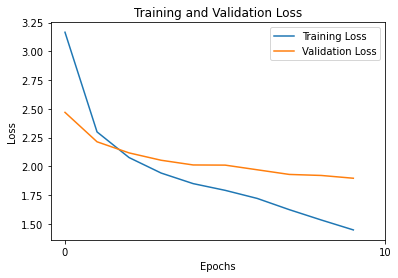

In [ ]:
# from matplotlib.pyplot import ylabel
# from matplotlib.pylab import plt
# from numpy import arange
# # Generate a sequence of integers to represent the epoch numbers
# y=range(0,10)
# # Plot and label the training and validation loss values
# plt.plot(y, train_loss_list, label='Training Loss')
# plt.plot(y, val_loss_list, label='Validation Loss')

# # Add in a title and axes labels
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')

# # Set the tick locations
# # plt.xticks(arange(0, epochs))
# plt.xticks(arange(0,11,10))

# # Display the plot
# plt.legend(loc='best')
# plt.show()

In [ ]:
checkpoint='checkpoint.tar'
if checkpoint:
  checkpoint=torch.load(checkpoint)
  model=checkpoint['model']

In [ ]:
while(1):
  dialog=input("User Input:")
  if dialog=='q':
    break
  enc_dialog=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in dialog.split()]
  dialog=torch.LongTensor(enc_dialog).to(device).unsqueeze(0)
  dialog_mask=(dialog!=0).to(device).unsqueeze(1).unsqueeze(1)
  sentence=evaluateChat(model,dialog,dialog_mask,MAX_LENGTH,vocab)
  print("Bot: {}".format(sentence))

User Input:नमस्कार कैसे हो तुम?
Bot: क्या आप मुझे एक देंगे, द्वारा
User Input:चलो कहीं बाहर खाने चलते हैं
Bot: क्या आप और कर सकते हैं
User Input:मैं आज बहुत खुश हूं
Bot: क्या आप मुझे एक और कर सकते हैं


KeyboardInterrupt: ignored

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from rouge import Rouge
# def calculateRogue(test_data):
#   prediction=[]
#   actual=[]
#   for pair in test_data:
#     dialog=pair[0]
#     enc_dialog=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in dialog.split()]
#     dialog=torch.LongTensor(enc_dialog).to(device).unsqueeze(0)
#     dialog_mask=(dialog!=0).to(device).unsqueeze(1).unsqueeze(1)
#     pred=evaluateChat(model,dialog,dialog_mask,MAX_LENGTH,vocab)
#     if len(pred)<=0:
#       continue
#     prediction.append(pred)
#     actual.append(pair[1])
#   rouge = Rouge()
#   scores = rouge.get_scores(prediction, actual,avg=True)
#   return scores

In [ ]:
##Bleu Score
def bleu_score(guess, answer):
    """Compute approximate BLEU score between guess and a set of answers."""
    bleu1=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[1,0,0,0])
    bleu2=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[0.5,0.5,0,0])
    bleu3=sentence_bleu([normalizeString(answer).split()],normalizeString(guess).split(" "),weights=[0.3,0.3,0.3,0])
    return [bleu1,bleu2,bleu3]

In [ ]:
##f1_score
def prec_recall_f1_score(pred_items, gold_items)->float:
    common = Counter(gold_items) & Counter(pred_items)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_items)
    recall = 1.0 * num_same / len(gold_items)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def f1_score(guess, answer)-> float:
    """Return the max F1 score between the guess and *any* answer."""
    if guess is None or answer is None:
        return 0
    g_tokens = normalizeString(guess).split()
    a_token=normalizeString(answer).split()
    return prec_recall_f1_score(g_tokens,a_token )

In [ ]:
##Meteor Score
def _meteor_score(guess,answer):
  return meteor_score([normalizeString(answer).split()],normalizeString(guess).split())

In [ ]:
def evaluateMetrics(test_data):
  num_samples=len(test_data)
  f1=0.0
  bleu=[0.0,0.0,0.0]
  meteor=0.0
  for pair in test_data:
    dialog=pair[0]
    actual=pair[1]
    enc_dialog=[vocab.word2idx.get(word,vocab.word2idx['OOV']) for word in dialog.split()]
    dialog=torch.LongTensor(enc_dialog).to(device).unsqueeze(0)
    dialog_mask=(dialog!=0).to(device).unsqueeze(1).unsqueeze(1)
    pred=evaluateChat(model,dialog,dialog_mask,MAX_LENGTH,vocab)
    f1+=f1_score(pred,actual)
    bleu=[a+b for a,b in zip(bleu,bleu_score(pred,actual))]
    meteor+=_meteor_score(pred,actual)
  f1=(f1/num_samples)*100
  bleu[:]=[(x/num_samples)*100 for x in bleu]
  meteor=(meteor/num_samples)*100
  print(f'F1_score: {f1:.2f}')
  print(f'BLEU-1_score: {bleu[0]:.3f}')
  print(f'BLEU-2_score: {bleu[1]:.3f}')
  print(f'BLEU-3_score: {bleu[2]:.2f}')
  print(f'meteor_score: {meteor:.2f}')
  return f1,bleu,meteor

In [ ]:
_,_,_=evaluateMetrics(pairs_test)
_,_=calculateRogue(pairs_test)

F1_score: 11.33
BLEU-1_score: 8.487
BLEU-2_score: 2.581
BLEU-3_score: 1.19
meteor_score: 7.29
{'rouge-1': {'r': 0.11634827620669214, 'p': 0.14192150054105987, 'f': 0.11713471403360766}, 'rouge-2': {'r': 0.026393339516045382, 'p': 0.03230168130535204, 'f': 0.026538519770754422}, 'rouge-l': {'r': 0.11346450700147566, 'p': 0.1385669623739889, 'f': 0.1142273238885117}}
